In [1]:
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance_matrix
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

import tqdm
from skimage.feature import hog
from skimage import data, exposure

In [2]:
path = "images-photographes"

In [3]:
def load_dataset(dir_sc, images_per_class=None):
    inames = []
    ilabels = []
    cnames = sorted(os.listdir(dir_sc))
    for ilabel, cl in enumerate(cnames):
        dir_cl = os.path.join(dir_sc, cl)
        for iname in os.listdir(dir_cl)[:images_per_class]:
            inames.append(os.path.join(cl, iname))
            ilabels.append(ilabel)
    ilabels = np.array(ilabels)
    return inames, ilabels, cnames

In [4]:
inames, ilabels, class_names = load_dataset(path)

In [5]:
class_names

['daido-moriyama',
 'dorothea-lange',
 'felix-nadar',
 'henri-cartier-bresson',
 'irving-penn',
 'malik-sidibe',
 'marc-riboud',
 'seidou-keita',
 'shomei-tomatsu',
 'walter-evans']

In [6]:
ilabels.shape

(280,)

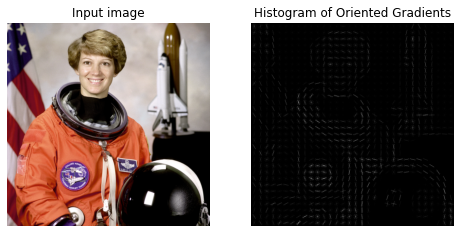

In [7]:
image = data.astronaut()

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [10]:
fd.shape

(8192,)

In [25]:
hog_image_rescaled.shape

(512, 512)

In [8]:
hog_image.shape

(512, 512)

In [26]:
def resize_image(img):
    return cv.resize(img, (1024, 1024),interpolation =cv.INTER_LINEAR)

In [27]:
def ComputeHoG(im, show = False):
    fd, hog_image = hog(im, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)
    if show == True:
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

        ax1.axis('off')
        ax1.imshow(im, cmap=plt.cm.gray)
        ax1.set_title('Input image')

        # Rescale histogram for better display
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

        ax2.axis('off')
        ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
        ax2.set_title('Histogram of Oriented Gradients')
        plt.show()

    return fd, hog_image

In [28]:
def ComputeHoGs(inames):

    Hogs = []
    features = []
    for i, x in enumerate(inames):
        print(i)
        p = os.path.join(path, x)
        img = cv.imread(p)
        gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        gray = resize_image(gray)
        feature, hog = ComputeHoG(gray)
        Hogs.append(hog)
        features.append(feature)
    
    return features, Hogs

In [29]:
features, hogs = ComputeHoGs(inames)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [30]:
len(hogs)

280

In [31]:
hogs[0].shape, hogs[1].shape

((1024, 1024), (1024, 1024))

In [32]:
features = np.array(features)

In [33]:
np.save('DATA_HOG.npy', features)

In [41]:
features= np.load('DATA_HOG.npy')

In [83]:
X_train, X_test, y_train, y_test = train_test_split(features ,ilabels,
                                                    test_size=0.2,stratify=ilabels)



In [59]:
np.unique(y_test, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([6, 4, 5, 9, 8, 7, 7, 2, 3, 5], dtype=int64))

In [60]:
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(224, 32768), (224,)
Test data and target sizes: 
(56, 32768), (56,)


In [53]:
from sklearn.preprocessing import StandardScaler

In [54]:
X_train = np.array(X_train)

In [84]:
test_accuracy = []
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled_Test = scaler.transform(X_test)
classifier = KNeighborsClassifier(n_neighbors=1,algorithm='brute')
classifier.fit(X_train, y_train)
test_accuracy = classifier.score(scaler.transform(X_scaled_Test), y_test)
print(test_accuracy)

0.26785714285714285


In [85]:
model_svm = SVC(C=40, kernel='linear', max_iter=10000, probability=True)
# Fit on sub-train set
# TODO
model_svm.fit(X_train, y_train)
# Evaluate on val set
# TODO
y_hat_test = model_svm.predict(X_test)
acc1 = accuracy_score(y_true=y_test, y_pred=y_hat_test)
print(f'--> accuracy = {acc1}')

--> accuracy = 0.39285714285714285


In [86]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [87]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
acc3 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",acc3)

Accuracy: 0.35714285714285715


In [88]:
from sklearn.ensemble import AdaBoostClassifier

In [89]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=100, learning_rate = 0.01)
# Train Adaboost Classifer
model4 = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_hat = model4.predict(X_test)

acc4 = model4.score(X_test, y_test)
print(f'--> accuracy = {acc4}')

--> accuracy = 0.2857142857142857


In [90]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
model_BC = BaggingClassifier(tree.DecisionTreeClassifier(random_state=2))
model_BC.fit(X_train, y_train)
acc5 = model_BC.score(X_test,y_test)
print(f'--> accuracy = {acc5}')

--> accuracy = 0.08928571428571429


In [91]:
eclf3 = VotingClassifier(estimators=[
      ('svc', model_svm), ('knn', classifier), ('rf', clf), ('ada', model4), ('Bagging', model_BC)],
       voting='soft',
       flatten_transform=True, weights=[1,1,1,1,1])

#results = model_selection.cross_val_score(ensemble, X, Y, cv=kfold)

eclf3 = eclf3.fit(X_train, y_train)
y_pred = eclf3.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f'--> accuracy = {acc}')

--> accuracy = 0.30357142857142855
